<a href="https://colab.research.google.com/github/tenten0727/benchmarkUpdate1/blob/master/benchmarkUpdate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# googleマウント

In [165]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# ライブラリのインポート

In [166]:
import pandas as pd
import lightgbm as lgb
import numpy as np
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from google.colab import files
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import datetime
import collections

warnings.simplefilter('ignore')


# data読み込み

In [167]:
train_df = pd.read_csv('/content/gdrive/My Drive/SIGNATE/Beginner1/train.csv')
test_df = pd.read_csv('/content/gdrive/My Drive/SIGNATE/Beginner1/test.csv')
submit_df = pd.read_csv('/content/gdrive/My Drive/SIGNATE/Beginner1/submit_sample.csv',header=None)

# data量確認

In [168]:
train_df.shape, test_df.shape, submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

# testデータがわかるようにダミーの目的変数を代入

In [169]:
test_df['y']=-999

# trainデータ、testデータを結合

In [170]:
all_df = pd.concat([train_df, test_df])
del train_df, test_df
gc.collect()
all_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


# カテゴリカラムの前処理

In [171]:
categorical_features = ['job', 'marital', 'education','default','housing','loan','contact','month','poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col]=lbl.transform(all_df[col])
# all_df = pd.get_dummies(all_df, drop_first=True)

all_df

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,7,1,1,0,12294,1,0,0,21,8,101,3,498,0,1,0
1,1,29,2,2,2,0,43027,0,0,0,22,1,158,2,702,0,3,1
2,2,35,4,1,2,0,12252,1,0,0,11,8,351,1,826,0,0,0
3,3,31,9,1,1,0,99121,1,1,2,16,7,658,2,120,0,0,0
4,4,48,10,1,0,0,42005,1,0,1,3,0,177,1,273,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18045,18045,49,6,1,2,0,98357,1,0,0,6,4,101,2,417,0,0,-999
18046,18046,34,1,1,1,0,29621,1,0,0,12,7,345,1,815,0,3,-999
18047,18047,34,0,2,1,0,94260,1,0,2,16,7,121,2,370,0,3,-999
18048,18048,31,9,2,1,0,65483,1,0,2,15,7,345,2,41,0,3,-999


## ターゲットエンコーディング

In [172]:
for category in categorical_features:
  target_mean = all_df[all_df['y'] != -999].groupby(category).y.mean()
  all_df['target_'+category] = all_df[category].map(target_mean)
  all_df[category].drop
  print(target_mean)


job
0     0.086602
1     0.057915
2     0.082251
3     0.090186
4     0.086607
5     0.167331
6     0.096303
7     0.065965
8     0.294618
9     0.042930
10    0.134591
Name: y, dtype: float64
marital
0    0.064476
1    0.062511
2    0.120704
Name: y, dtype: float64
education
0    0.065185
1    0.064369
2    0.104498
3    0.151993
Name: y, dtype: float64
default
0    0.077962
1    0.000000
Name: y, dtype: float64
housing
0    0.130219
1    0.040647
Name: y, dtype: float64
loan
0    0.084352
1    0.033923
Name: y, dtype: float64
contact
0    0.091346
1    0.089674
2    0.038546
Name: y, dtype: float64
month
0     0.203491
1     0.068323
2     0.148661
3     0.127424
4     0.086786
5     0.057032
6     0.462617
7     0.044160
8     0.062852
9     0.567010
10    0.296296
Name: y, dtype: float64
poutcome
0    0.043798
1    0.048426
2    0.679039
3    0.071085
Name: y, dtype: float64


## Count Encoding

In [173]:
# for category in categorical_features:
#   counters = collections.Counter(all_df[category].values)
#   all_df['count_'+category] = all_df[category].map(counters)
#   all_df[category].drop

# all_df.head()

# train, testに再度分割

In [174]:
train_df = all_df[all_df['y'] != -999]
test_df = all_df[all_df['y'] == -999]

y_train = train_df['y']
X_train = train_df.drop(['y', 'id'], axis=1)
X_test = test_df.drop(['y', 'id'], axis=1)

# trainをさらに分割

In [175]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

# lightbgmを使用

In [176]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    'objective': 'binary'
}

model = lgb.train(
    params, lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    verbose_eval=10,
    num_boost_round=1000,
    early_stopping_rounds=10
)



Training until validation scores don't improve for 10 rounds.
[10]	training's binary_logloss: 0.208383	valid_1's binary_logloss: 0.218796
[20]	training's binary_logloss: 0.190343	valid_1's binary_logloss: 0.208316
[30]	training's binary_logloss: 0.178661	valid_1's binary_logloss: 0.204084
[40]	training's binary_logloss: 0.169663	valid_1's binary_logloss: 0.202956
[50]	training's binary_logloss: 0.161684	valid_1's binary_logloss: 0.202438
Early stopping, best iteration is:
[46]	training's binary_logloss: 0.164389	valid_1's binary_logloss: 0.202051


# バリデーション

In [177]:
y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
accuracy = accuracy_score(y_valid, y_valid_pred.round())
accuracy

0.9333333333333333

# 重要度出力

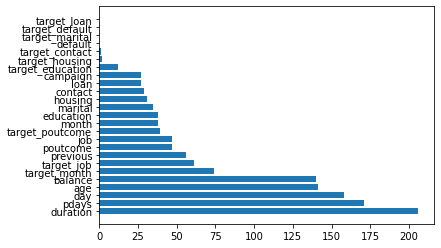

In [178]:
cols = list(X_train.columns)
f_importance = np.array(model.feature_importance())
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False)
plt.barh(df_importance['feature'], df_importance['importance'])
plt.show()

In [179]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
print(y_pred)
# 反応率を出力

[0.7795774  0.0641832  0.02771028 ... 0.0771145  0.00796539 0.1026451 ]


# 提出ファイル作成

In [180]:
submit_df[1]=y_pred
submit_df.to_csv('beginner-'+datetime.date.today().isoformat()+".csv", index=False, header=False) #headerなしで出力
files.download('beginner-'+datetime.date.today().isoformat()+".csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>